<a href="https://colab.research.google.com/github/badbloody/diploma2023/blob/main/fid_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import random
import shutil

def create_subset_folder(dataset_path, save_path, subset_size):
    # Create the save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # List all image files in the dataset directory
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Randomly choose a subset of images
    subset_files = random.sample(image_files, subset_size)

    # Copy the chosen subset of images to the save directory
    for image_file in subset_files:
        src_path = os.path.join(dataset_path, image_file)
        dst_path = os.path.join(save_path, image_file)
        shutil.copy(src_path, dst_path)

    print(f"Created a subset of {subset_size} images in '{save_path}'.")

# Parameters
dataset_path = "/content/gdrive/MyDrive/content_dataset_train/train"
save_path = "/content/gdrive/MyDrive/FID_content/train"
subset_size = 10  # Choose the desired subset size

# Create and save the subset of images
create_subset_folder(dataset_path, save_path, subset_size)

Created a subset of 10 images in '/content/gdrive/MyDrive/FID_content/train'.


In [ ]:
# example of calculating the frechet inception distance in Keras for cifar10
import numpy
import numpy as np
import tensorflow as tf
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10

# scale an array of images to a new size
def scale_images(images, new_shape):
 images_list = list()
 for image in images:
    # resize with nearest neighbor interpolation
    new_image = resize(image, new_shape, 0)

    # store
    images_list.append(new_image)
 return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2, batch_size=32):
  act1_list = []
  act2_list = []
  for i in range(0, len(images1), batch_size):
      batch_images1 = images1[i:i+batch_size]
      batch_images2 = images2[i:i+batch_size]

      act1_batch = model.predict(batch_images1)
      act2_batch = model.predict(batch_images2)

      act1_list.append(act1_batch)
      act2_list.append(act2_batch)

  act1 = np.concatenate(act1_list, axis=0)
  act2 = np.concatenate(act2_list, axis=0)

  # calculate mean and covariance statistics
  mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)

  # calculate sum squared difference between means
  ssdiff = numpy.sum((mu1 - mu2)**2.0)

  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))

  # check and correct imaginary numbers from sqrt
  if iscomplexobj(covmean):
    covmean = covmean.real

  # calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# load cifar10 images
(images1, _), (images2, _) = cifar10.load_data()
shuffle(images1)
shuffle(images2)
images1 = images1[:10]
images2 = images2[:10]
print('Loaded', images1.shape, images2.shape)

# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')

# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)

# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

batch_size = 32
fid = calculate_fid(model, images1, images2, batch_size)
print('FID: %.3f' % fid)

# Clear TensorFlow session to release GPU memory
tf.keras.backend.clear_session()

Loaded (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 0s 34ms/step
FID: 361.146


Loading model


In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
from collections import defaultdict

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        outs = []
        for name, module in self.features._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                outs.append(x)
        return outs

class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(MyConv2D, self).__init__()
        self.weight = torch.zeros((out_channels, in_channels, kernel_size, kernel_size)).to(device)
        self.bias = torch.zeros(out_channels).to(device)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)

    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        return s.format(**self.__dict__)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1),
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x


def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1,
    upsample=None, instance_norm=True, relu=True, trainable=False):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    if trainable:
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    else:
        layers.append(MyConv2D(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers


class TransformNet(nn.Module):
    def __init__(self, base=8):
        super(TransformNet, self).__init__()
        self.base = base
        self.weights = []
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9, trainable=True),
            *ConvLayer(base, base*2, kernel_size=3, stride=2),
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2),
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False, trainable=True),
        )
        self.get_param_dict()

    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y

    def get_param_dict(self):
        param_dict = defaultdict(int)
        def dfs(module, name):
            for name2, layer in module.named_children():
                dfs(layer, '%s.%s' % (name, name2) if name != '' else name2)
            if module.__class__ == MyConv2D:
                param_dict[name] += int(np.prod(module.weight.shape))
                param_dict[name] += int(np.prod(module.bias.shape))
        dfs(self, '')
        return param_dict

    def set_my_attr(self, name, value):
        target = self
        for x in name.split('.'):
            if x.isnumeric():
                target = target.__getitem__(int(x))
            else:
                target = getattr(target, x)

        n_weight = np.prod(target.weight.shape)
        target.weight = value[:n_weight].view(target.weight.shape)
        target.bias = value[n_weight:].view(target.bias.shape)

    def set_weights(self, weights, i=0):
        for name, param in weights.items():
            self.set_my_attr(name, weights[name][i])

    def reset_weights(self):
      for name, param in self.named_children():
          if isinstance(param, MyConv2D):
              with torch.no_grad():
                  weight_size = int(np.prod(param.weight.shape))
                  bias_size = int(np.prod(param.bias.shape))
                  initial_weights = torch.randn(weight_size + bias_size)
                  self.set_my_attr(name, initial_weights)

class MetaNet(nn.Module):
    def __init__(self, param_dict):
        super(MetaNet, self).__init__()
        self.param_num = len(param_dict)
        self.hidden = nn.Linear(1920, 128*self.param_num)
        self.fc_dict = {}
        for i, (name, params) in enumerate(param_dict.items()):
            self.fc_dict[name] = i
            setattr(self, 'fc{}'.format(i+1), nn.Linear(128, params))

    def forward(self, mean_std_features):
        hidden = F.relu(self.hidden(mean_std_features))
        filters = {}
        for name, i in self.fc_dict.items():
            fc = getattr(self, 'fc{}'.format(i+1))
            filters[name] = fc(hidden[:,i*128:(i+1)*128])
        return filters

    def forward2(self, mean_std_features):
        hidden = F.relu(self.hidden(mean_std_features))
        filters = {}
        for name, i in self.fc_dict.items():
            fc = getattr(self, 'fc{}'.format(i+1))
            filters[name] = fc(hidden[:,i*128:(i+1)*128])
        return filters

In [64]:
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]
tensor_normalizer = transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std)
epsilon = 1e-5

def preprocess_image(image, target_width=None):
    if image.mode == "RGBA":
        image = image.convert("RGB")  # Convert RGBA to RGB

    if target_width:
        t = transforms.Compose([
            transforms.Resize(target_width),
            transforms.CenterCrop(target_width),
            transforms.ToTensor(),
            tensor_normalizer,
        ])
    else:
        t = transforms.Compose([
            transforms.ToTensor(),
            tensor_normalizer,
        ])
    return t(image).unsqueeze(0)


def image_to_tensor(image, target_width=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    return preprocess_image(image, target_width)


def read_image(path, target_width=None):
    image = Image.open(path)
    return preprocess_image(image, target_width)


def recover_image(tensor):
    image = tensor.detach().cpu().numpy()
    image = image * np.array(cnn_normalization_std).reshape((1, 3, 1, 1)) + \
    np.array(cnn_normalization_mean).reshape((1, 3, 1, 1))
    return (image.transpose(0, 2, 3, 1) * 255.).clip(0, 255).astype(np.uint8)[0]


def recover_tensor(tensor):
    m = torch.tensor(cnn_normalization_mean).view(1, 3, 1, 1).to(tensor.device)
    s = torch.tensor(cnn_normalization_std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * s + m
    return tensor.clamp(0, 1)


def imshow(tensor, title=None):
    image = recover_image(tensor)
    print(image.shape)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


def mean_std(features):
    mean_std_features = []
    for x in features:
        x = x.view(*x.shape[:2], -1)
        x = torch.cat([x.mean(-1), torch.sqrt(x.var(-1) + epsilon)], dim=-1)
        n = x.shape[0]
        x2 = x.view(n, 2, -1).transpose(2, 1).contiguous().view(n, -1) # 【mean, ..., std, ...] to [mean, std, ...]
        mean_std_features.append(x2)
    mean_std_features = torch.cat(mean_std_features, dim=-1)
    return mean_std_features


class Smooth:
    def __init__(self, windowsize=100):
        self.window_size = windowsize
        self.data = np.zeros((self.window_size, 1), dtype=np.float32)
        self.index = 0

    def __iadd__(self, x):
        if self.index == 0:
            self.data[:] = x
        self.data[self.index % self.window_size] = x
        self.index += 1
        return self

    def __float__(self):
        return float(self.data.mean())

    def __format__(self, f):
        return self.__float__().__format__(f)

In [13]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()

In [89]:
base = 32
transform_net = TransformNet(base).to(device)
transform_net.get_param_dict()

defaultdict(int,
            {'downsampling.5': 18496,
             'downsampling.9': 73856,
             'residuals.0.conv.1': 147584,
             'residuals.0.conv.5': 147584,
             'residuals.1.conv.1': 147584,
             'residuals.1.conv.5': 147584,
             'residuals.2.conv.1': 147584,
             'residuals.2.conv.5': 147584,
             'residuals.3.conv.1': 147584,
             'residuals.3.conv.5': 147584,
             'residuals.4.conv.1': 147584,
             'residuals.4.conv.5': 147584,
             'upsampling.2': 73792,
             'upsampling.7': 18464})

In [90]:
transform_net

TransformNet(
  (downsampling): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): MyConv2D(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (6): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): ReLU()
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): MyConv2D(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (10): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): ReLU()
  )
  (residuals): Sequential(
    (0): ResidualBlock(
      (conv): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): MyConv2D(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU()
        (4): Re

In [91]:
metanet = MetaNet(transform_net.get_param_dict()).to(device)

In [92]:
metanet.load_state_dict(torch.load('/content/gdrive/MyDrive/myOwnModels/metanet_base32_style50_tv1e-06.pth'))
transform_net.load_state_dict(torch.load('/content/gdrive/MyDrive/myOwnModels/metanet_base32_style50_tv1e-06_transform_net.pth'))

OutOfMemoryError: ignored

In [18]:
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std)
])


In [19]:
content_dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/FID_content', transform=data_transform)

In [20]:
style_image = read_image('/content/gdrive/MyDrive/diplomskiSlike/portraits/portrait005.jpg', target_width=256).to(device)
style_features = vgg16(style_image)
style_mean_std = mean_std(style_features)

In [21]:
import torch.optim as optim

style_weight = 50
content_weight = 1
tv_weight = 1e-6
batch_size = 8

trainable_params = {}
trainable_param_shapes = {}
for model in [vgg16, transform_net, metanet]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params[name] = param
            trainable_param_shapes[name] = param.shape

optimizer = optim.Adam(trainable_params.values(), 1e-3)
content_data_loader = torch.utils.data.DataLoader(content_dataset, batch_size=batch_size, shuffle=True)

In [27]:
content_imagess = content_dataset[0]

In [28]:
from tqdm import tqdm

n_batch = 20
with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
    for batch, (content_images, _) in pbar:
        x = content_images.cpu().numpy()
        if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
            continue

        optimizer.zero_grad()

        weights = metanet.forward2(mean_std(style_features))
        transform_net.set_weights(weights, 0)

        content_images = content_images.to(device)
        transformed_images = transform_net(content_images)

        content_features = vgg16(content_images)
        transformed_features = vgg16(transformed_images)
        transformed_mean_std = mean_std(transformed_features)

        # content loss
        content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])

        # style loss
        style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                               style_mean_std.expand_as(transformed_mean_std))

        # total variation loss
        y = transformed_images
        tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        loss = content_loss + style_loss + tv_loss

        loss.backward()
        optimizer.step()

        if batch > n_batch:
            break

 10%|█         | 2/20 [00:00<00:05,  3.17it/s]


FID CODE

In [30]:
# Save transferred images
def save_transferred_images(content_images, model, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for idx, content_image in enumerate(content_images):
        # Perform neural style transfer
        #transferred_image = perform_style_transfer(content_image, model)
        transferred_image = model(content_image)

        # Save the transferred image
        save_path = os.path.join(save_dir, f"transferred_image_{idx}.jpg")
        transferred_image.save(save_path)
        print(f"Saved transferred image {idx + 1}/{len(content_images)}")

In [43]:
content_imagess = torch.stack([content_dataset[i][0] for i in range(len(content_dataset))]).to(device)
transformed_images = transform_net(content_imagess)

In [49]:
from torchvision.utils import save_image

for idx, transformed_image in enumerate(transformed_images):
    transformed_image = recover_image(transformed_image)
    pil_image = Image.fromarray(transformed_image)
    pil_image.save(os.path.join("/content/gdrive/MyDrive/FID_transferred_sketch", f"transformed_{idx}.jpg"))
    #save_image(recover_image(transformed_image), os.path.join("/content/gdrive/MyDrive/FID_transferred_2", f"transformed_{idx}.jpg"))


In [51]:
os.makedirs("/content/gdrive/MyDrive/FID_content_2", exist_ok=True)

In [53]:
for idx, content_image in enumerate(content_imagess):
    content_image= recover_image(content_image)
    pil_image = Image.fromarray(content_image)
    pil_image.save(os.path.join("/content/gdrive/MyDrive/FID_content_2", f"transformed_{idx}.jpg"))
    #save_image(recover_image(transformed_image), os.path.join("/content/gdrive/MyDrive/FID_transferred_2", f"transformed_{idx}.jpg"))

(256, 256, 3)
(256, 2560, 3)
(256, 2560, 3)


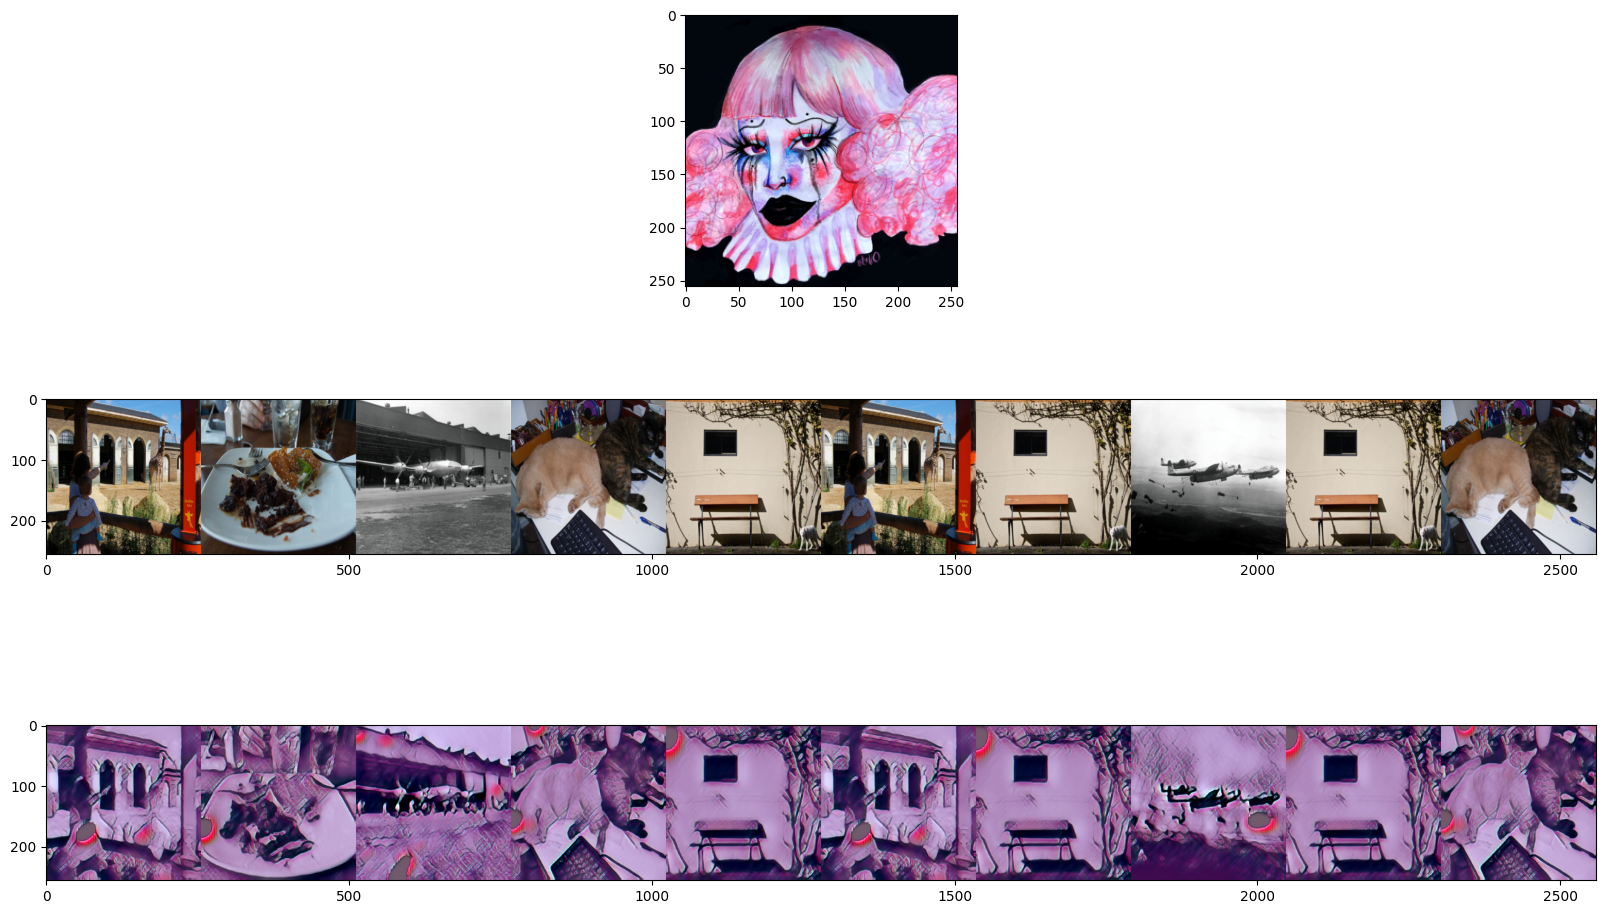

In [42]:
plt.figure(figsize=(20, 12))
plt.subplot(3, 1, 1)
imshow(style_image)
plt.subplot(3, 1, 2)
imshow(content_images_vis)
plt.subplot(3, 1, 3)
imshow(transformed_images_vis)

In [54]:
import numpy as np
import tensorflow as tf
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
import os
from PIL import Image

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)

        # store
        images_list.append(new_image)
    return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2, batch_size=32):
    act1_list = []
    act2_list = []
    for i in range(0, len(images1), batch_size):
        batch_images1 = images1[i:i+batch_size]
        batch_images2 = images2[i:i+batch_size]

        act1_batch = model.predict(batch_images1)
        act2_batch = model.predict(batch_images2)

        act1_list.append(act1_batch)
        act2_list.append(act2_batch)

    act1 = np.concatenate(act1_list, axis=0)
    act2 = np.concatenate(act2_list, axis=0)

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Load images from local folders
content_images_dir = "/content/gdrive/MyDrive/FID_content_2"
transformed_images_dir = "/content/gdrive/MyDrive/FID_transferred_2"

content_images = []
transformed_images = []

for image_file in os.listdir(content_images_dir):
    image_path = os.path.join(content_images_dir, image_file)
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)
    content_images.append(image)

    transformed_image_path = os.path.join(transformed_images_dir, image_file)
    transformed_image = Image.open(transformed_image_path).convert("RGB")
    transformed_image = np.array(transformed_image)
    transformed_images.append(transformed_image)

content_images = np.array(content_images)
transformed_images = np.array(transformed_images)

# convert integer to floating point values
images1 = content_images.astype('float32')
images2 = transformed_images.astype('float32')

# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))

# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

batch_size = 32
fid = calculate_fid(model, images1, images2, batch_size)
print('FID: %.3f' % fid)

# Clear TensorFlow session to release GPU memory
tf.keras.backend.clear_session()


1/1 [==============================] - 0s 38ms/step
FID: 424.137


Checking FID on the NON-resized content images: - they need to have the same name

In [56]:

model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Load images from local folders
content_images_dir = "/content/gdrive/MyDrive/FID_content/train"
transformed_images_dir = "/content/gdrive/MyDrive/FID_transferred_2"

content_images = []
transformed_images = []

for image_file in os.listdir(content_images_dir):
    image_path = os.path.join(content_images_dir, image_file)
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)
    content_images.append(image)

    transformed_image_path = os.path.join(transformed_images_dir, image_file)
    transformed_image = Image.open(transformed_image_path).convert("RGB")
    transformed_image = np.array(transformed_image)
    transformed_images.append(transformed_image)

content_images = np.array(content_images)
transformed_images = np.array(transformed_images)

# convert integer to floating point values
images1 = content_images.astype('float32')
images2 = transformed_images.astype('float32')

# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))

# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

batch_size = 32
fid = calculate_fid(model, images1, images2, batch_size)
print('FID: %.3f' % fid)

# Clear TensorFlow session to release GPU memory
tf.keras.backend.clear_session()

FileNotFoundError: ignored

2nd style image


In [85]:
style_image = read_image('/content/gdrive/MyDrive/diplomskiSlike/sketches/sketch003.png', target_width=256).to(device)
style_features = vgg16(style_image)
style_mean_std = mean_std(style_features)

In [86]:
style_weight = 50
content_weight = 1
tv_weight = 1e-6
batch_size = 8

trainable_params = {}
trainable_param_shapes = {}
for model in [vgg16, transform_net, metanet]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params[name] = param
            trainable_param_shapes[name] = param.shape

optimizer = optim.Adam(trainable_params.values(), 1e-3)
content_data_loader = torch.utils.data.DataLoader(content_dataset, batch_size=batch_size, shuffle=True)

In [93]:
from tqdm import tqdm

transform_net.reset_weights()
n_batch = 20
with tqdm(enumerate(content_data_loader), total=n_batch) as pbar:
    for batch, (content_images, _) in pbar:
        x = content_images.cpu().numpy()
        if (x.min(-1).min(-1) == x.max(-1).max(-1)).any():
            continue

        optimizer.zero_grad()

        weights = metanet.forward(mean_std(style_features))
        transform_net.set_weights(weights, 0)

        content_images = content_images.to(device)
        transformed_images = transform_net(content_images)

        content_features = vgg16(content_images)
        transformed_features = vgg16(transformed_images)
        transformed_mean_std = mean_std(transformed_features)

        # content loss
        content_loss = content_weight * F.mse_loss(transformed_features[2], content_features[2])

        # style loss
        style_loss = style_weight * F.mse_loss(transformed_mean_std,
                                               style_mean_std.expand_as(transformed_mean_std))

        # total variation loss
        y = transformed_images
        tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
                                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        loss = content_loss + style_loss + tv_loss

        loss.backward()
        optimizer.step()

        if batch > n_batch:
            break

  0%|          | 0/20 [00:00<?, ?it/s]


OutOfMemoryError: ignored

In [78]:
content_imagess = torch.stack([content_dataset[i][0] for i in range(len(content_dataset))]).to(device)
transformed_images = transform_net(content_imagess)

In [79]:
from torchvision.utils import save_image

os.makedirs("/content/gdrive/MyDrive/FID_transferred_sketch", exist_ok=True)

for idx, transformed_image in enumerate(transformed_images):
    transformed_image = recover_image(transformed_image)
    pil_image = Image.fromarray(transformed_image)
    pil_image.save(os.path.join("/content/gdrive/MyDrive/FID_transferred_sketch", f"transformed_{idx}.jpg"))